In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

#Import Aveiro's tools
import sys  
sys.path.insert(1, '/Users/jcaravaca/Work_Local/install/spectUCSF')
from src.Reader import ListModeReader

# %load_ext autoreload
# %autoreload 2
sys.path.insert(1, '/Users/jcaravaca/Dropbox/Work/code/jupyter-notebooks/BMI/M400')
import M400Tools as M400

## Vector

In [2]:
filenames = glob.glob('/Users/jcaravaca/Work_Local/data_overflow/IDEAS-CZT-SPECT/images/VECTor/2023-08-30_12h02_Ac225_mousephantom_SDJavier/listmode/scan-0_*.hist')

In [3]:
datasets = [pd.read_csv(filename,delimiter=' ',skiprows=6,names=['Energy','Det0','Det1','Det2','None']) for filename in filenames]
datasets[0]

,Energy,Det0,Det1,Det2,None
0,2.34375,2,0,0,NaN
1,4.68750,0,0,0,NaN
2,7.03125,0,0,0,NaN
3,9.37500,0,4,0,NaN
4,11.71875,89,83,23,NaN
...,...,...,...,...,...
506,1188.28125,11,9,9,NaN
507,1190.62500,16,8,14,NaN
508,1192.96875,12,14,11,NaN
509,1195.31250,11,17,19,NaN


In [4]:
# Sum datasets
energies = datasets[0]['Energy'].values
spectra_det0 = datasets[0]['Det0'].values
spectra_det1 = datasets[0]['Det1'].values
spectra_det2 = datasets[0]['Det2'].values
for dataset in datasets:
    spectra_det0 += dataset['Det0'].values
    spectra_det1 += dataset['Det1'].values
    spectra_det2 += dataset['Det2'].values

spectra_all = spectra_det0 + spectra_det1

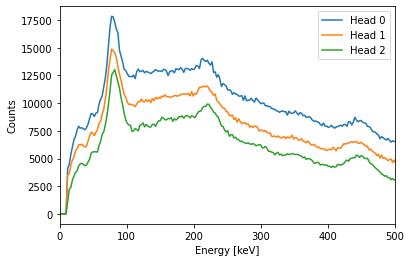

In [5]:
plt.plot(energies,spectra_det0,label='Head 0')
plt.plot(energies,spectra_det1,label='Head 1')
plt.plot(energies,spectra_det2,label='Head 2')
plt.ylabel('Counts')
plt.xlabel('Energy [keV]')
plt.xlim(0,500)
plt.legend()
plt.show()

## CZT SPECT

In [6]:
filename = '/Users/jcaravaca/Work_Local/data_overflow/IDEAS-CZT-SPECT/images/Mouse_Phantom_Ac-225_2023-12-10_14hr13m14s/2nCi_86400s.npy'

r = ListModeReader(filename)
r.readFile()

1
1
_version: 1
_deviceName: 2_IDEAS
_deviceObject: None
_acquisitionTime: 14hr13m14s
_acquisitionDate: 2023-12-10
_acquisitionTimeLenght: 86400
_radioisotope: Ac-225
_activityUnit: nCi
_activityAtInjectionDate: 2
_activityConcentration: 0.5
_injectionDate: 2020-01-01
_injectionTime: 00h00m00s
_concentrationUnits: uCi/mL
_volumeInjected: 0
_subjectPosition: HF
_subjectID: Mouse_Phantom
_subjectType: None
_subjectWeight: 0
   module_id  detector_id  asics_id  channel_id  channel_uniqueid  timestamp  \
0         11            2         0         113              2929  501882016   
1         11            2         0         113              2929  501926807   
2         18            3         1          95              4831  501963142   
3          2            0         1         109               749  501964660   
4          2            0         1         109               749  502008861   

   timestamp_delta      energy  
0        242925685  400.890015  
1            44791    4.200

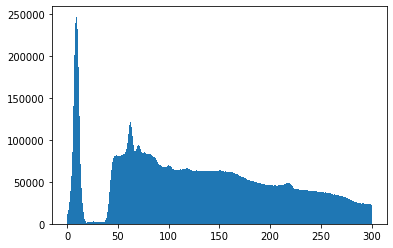

In [7]:
h = plt.hist(r.listMode.energy, bins=300,range=[0,300])
plt.show()

## M400

In [8]:
# DETECTOR_POS = np.array([-135,0,0]) # (x,y,z) in mm
# DETECTOR_POS = np.array([-50,0,0]) # (x,y,z) in mm
DETECTOR_POS = np.array([-20,0,0]) # (x,y,z) in mm
DETECTOR_ZAXIS = np.array([1.,0.,0.]) # Direction of Z axis of detector
DETECTOR_ZROT = 0. # Rotation around Z axis
ENERGY_RANGE = [50,500]

path = '/Users/jcaravaca/Dropbox/Work/projects/M400/data/experimental/'
# filename = 'AllEvents_Ac225_1stMay_5inchDist_middle_.txt' #5.6Mb
# filename = 'AllEvents_Ac225_4cmDist_3May_middle_.txt' #34Mb
# filename = 'AllEvents_Ac225_4cmDist_3May_4cmRight_.txt' #22Mb
# filename = 'AllEvents_Ac225_4cmDist_3May_4cmLeft_.txt' #21Mb
# filename = 'AllEvents_Ac225_1cmDist_3May_.txt' #52Mb
# filename = 'AllEvents_225Ac_pointSource_testing_run2.txt'
filename = 'AllEvents_txt_NewMousePhantom_WC_37mmUp_p22degRot_17July_run_12.txt'


In [9]:
df = M400.readM400csvfile(path+filename, 
                          translation = DETECTOR_POS,
                          z_axis = DETECTOR_ZAXIS,
                          z_rotation = DETECTOR_ZROT)


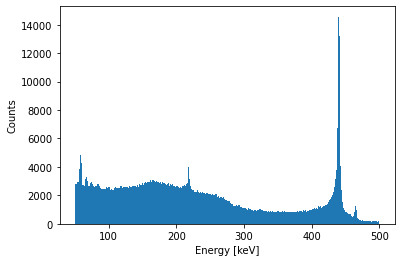

In [10]:
energies_m400 = df['Energy']

plt.hist(energies_m400,bins=500,range=ENERGY_RANGE)
plt.xlabel('Energy [keV]')
plt.ylabel('Counts')
# plt.yscale('log')
plt.show()

## Final plot

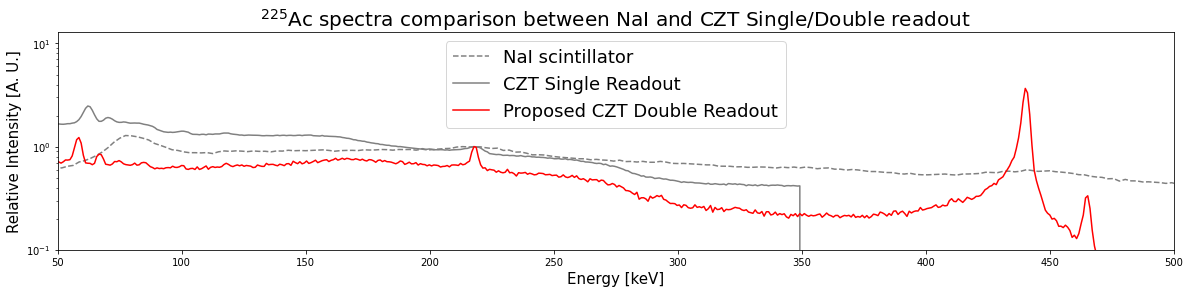

In [13]:
PHOTOPEAK_WIDTH = 0.20

WINDOW_XRAYS = [113*(1-PHOTOPEAK_WIDTH/2.), 113*(1+PHOTOPEAK_WIDTH/2.)]
WINDOW_FR = [140*(1-PHOTOPEAK_WIDTH/2.), 140*(1+PHOTOPEAK_WIDTH/2.)]

#Normalize CZT SPECT to Fr peak

spectra_vector_norm = spectra_all/np.max(spectra_all[energies>200])
spectra_czt, e_bins = np.histogram(r.listMode.energy, bins=500,range=ENERGY_RANGE)
e_czt = (np.roll(e_bins,-1) + e_bins)/2.
e_czt = e_czt[0:-1]
spectra_czt_norm = spectra_czt/np.max(spectra_czt[(e_czt>200) & (e_czt<300)])
spectra_m400, e_bins = np.histogram(energies_m400, bins=500,range=ENERGY_RANGE)
spectra_m400_norm = spectra_m400/np.max(spectra_m400[(e_czt>200) & (e_czt<300)])


# Dynamic range cut: put values after 350keV to zero
spectra_czt_norm[e_czt>350] = 0.

plt.figure(figsize=(20,4))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.plot(energies,spectra_vector_norm,color='Gray',label='NaI scintillator',linestyle='--')
plt.plot(e_czt,spectra_czt_norm,color='Gray',label='CZT Single Readout')
plt.plot(e_czt,spectra_m400_norm,color='Red',label='Proposed CZT Double Readout')
# plt.plot(e_czt,spectra_m400_norm,color='Red',label='CZT semiconductor')

# h = plt.hist(r.listMode.energy, bins=500,range=[0,300])
# plt.plot([WINDOW_XRAYS,WINDOW_XRAYS],[0,np.max(spectra_vector_norm)],color='C1',linestyle='--')
# plt.plot([WINDOW_FR,WINDOW_FR],[0,np.max(spectra_vector_norm)],color='C2',linestyle='--')

plt.ylabel('Relative Intensity [A. U.]',size=15)
plt.xlabel('Energy [keV]',size=15)

plt.xlim(ENERGY_RANGE)
# plt.ylim(0,np.max(spectra_vector_norm)*4.)
plt.ylim(1e-1,np.max(spectra_vector_norm)*10)
plt.yscale('log')

# plt.text(60,1.0, ('Collimator X-rays'),color='black',rotation=45,wrap=True)
# plt.text(80,0.68,('$^{225}$Ac X-rays'),color='black',rotation=45,wrap=True)
# plt.text(105,0.55,('$^{225}$Ac $\gamma$-ray'),color='black',rotation=45,wrap=True)
# plt.text(120,0.55,('$^{209}$Tl'),color='black',rotation=45,wrap=True)
# plt.text(220,0.40,('$^{221}$Fr'),color='black',rotation=45,wrap=True)

plt.title('$^{225}$Ac spectra comparison between NaI and CZT Single/Double readout',fontsize=20)
plt.legend(fontsize=18,loc='upper center')

plt.savefig('plots/energy_vector_ac225.pdf')

plt.show()